In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
    auc, roc_curve

In [3]:
from NN_utils.Layers.Conv2d import Conv2d
from NN_utils.Layers.Linear import Linear
from NN_utils.Layers.MaxPool2d import MaxPool2d
from NN_utils.Layers.AvgPool2d import AvgPool2d
from NN_utils.Layers.Flatten import Flatten
from NN_utils.Activations.ReLU import ReLU
from NN_utils.Activations.Softmax import Softmax

from NN_utils.NeuralNetwork import NeuralNetwork
from NN_utils.Losses.CrossEntropy import CrossEntropy

In [4]:
seed = 23
rng = np.random.default_rng(seed)

## Loading data

In [5]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [6]:
(x_train, y_train), (x_test, y_test) = load_data("../data/3. mnist.npz")

## Class distribution

In [7]:
unique, counts = np.unique(y_train, return_counts=True)

df = pd.DataFrame(counts, columns=["Counts"])

In [8]:
print(df.sort_values("Counts", ascending=False))

   Counts
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421


<Axes: ylabel='Counts'>

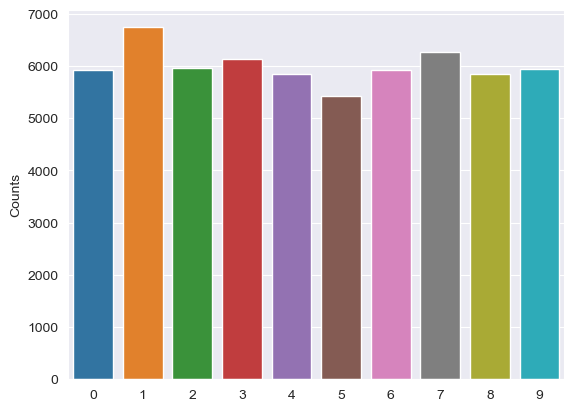

In [9]:
sns.barplot(df, x=df.index.values, y="Counts")

## t-SNE

In [10]:
embed = TSNE(n_components=2, perplexity=10, learning_rate=200, n_iter=1000)

In [11]:
X_embedded = embed.fit_transform(x_train.reshape(x_train.shape[0], 28 * 28))

In [12]:
print(f'Kullback–Leibler divergence: {embed.kl_divergence_}')

Kullback–Leibler divergence: 3.472362518310547


In [13]:
fig = px.scatter(None, x=X_embedded[:, 0], y=X_embedded[:, 1],
                 labels={"x": "Dimension 1", "y": "Dimension 2", },
                 opacity=1, color=y_train.astype(str))
fig.update_layout(dict(plot_bgcolor='white'))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

fig.update_layout(title_text="t-SNE")
fig.update_traces(marker=dict(size=3))

fig.show()

## Data preproccessing

In [14]:
num_classes = 10

In [15]:
x_train = np.expand_dims(x_train, axis=1).astype(float)
x_test = np.expand_dims(x_test, axis=1).astype(float)
x_train /= 255.
x_test /= 255.

In [16]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
# one-hot-encoding
y_train = np.expand_dims(np.eye(num_classes)[y_train.flatten()], axis=2)
y_test = np.expand_dims(np.eye(num_classes)[y_test.flatten()], axis=2)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 1, 28, 28)
(60000, 10, 1)
(10000, 1, 28, 28)
(10000, 10, 1)


# Building network

In [18]:
CNN = NeuralNetwork()

In [19]:
# Feature extractor
CNN.add(Conv2d(in_channels=1, out_channels=2, kernel_size=3, random_seed=seed))  # 2 x 26 x 26
CNN.add(ReLU())
CNN.add(AvgPool2d(kernel_size=2))  # 2 x 13 x 13
CNN.add(Conv2d(in_channels=2, out_channels=3, kernel_size=3, random_seed=seed))  # 3 x 11 x 11
CNN.add(ReLU())
CNN.add(AvgPool2d(kernel_size=2))  # 3 x 5 x 5
CNN.add(Flatten())
# Head
CNN.add(Linear(in_neurons=3 * 5 * 5, out_neurons=32, random_seed=seed))
CNN.add(ReLU())
CNN.add(Linear(in_neurons=32, out_neurons=num_classes, random_seed=seed))
CNN.add(Softmax())

Other options for network architectures. I did not use them due to the large amount of time required for CPU training

In [23]:
# Feature extractor
# CNN.add(Conv2d(in_channels=1, out_channels=6, kernel_size=5, random_seed=seed))  # 6 x 24 x 24
# CNN.add(ReLU())
# CNN.add(AvgPool2d(kernel_size=2))  # 6 x 12 x 12
# CNN.add(Conv2d(in_channels=6, out_channels=16, kernel_size=5, random_seed=seed))  # 16 x 8 x 8
# CNN.add(ReLU())
# CNN.add(AvgPool2d(kernel_size=2))  # 16 x 4 x 4
# CNN.add(Flatten())
# # Head
# CNN.add(Linear(in_neurons=16 * 4 * 4, out_neurons=120, random_seed=seed))
# CNN.add(ReLU())
# CNN.add(Linear(in_neurons=120, out_neurons=84, random_seed=seed))
# CNN.add(ReLU())
# CNN.add(Linear(in_neurons=84, out_neurons=10, random_seed=seed))
# CNN.add(Softmax())

In [ ]:
# # Feature extractor
# CNN.add(Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1, random_seed=seed))  # 6 x 28 x 28
# CNN.add(ReLU())
# CNN.add(MaxPool2d(kernel_size=2))  # 32 x 14 x 14
# CNN.add(Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1, random_seed=seed))  # 16 x 14 x 14
# CNN.add(ReLU())
# CNN.add(MaxPool2d(kernel_size=2))  # 16 x 7 x 7
# CNN.add(Flatten())
# # Head
# CNN.add(Linear(in_neurons=16 * 7 * 7, out_neurons=128, random_seed=seed))
# CNN.add(ReLU())
# CNN.add(Linear(in_neurons=128, out_neurons=num_classes, random_seed=seed))
# CNN.add(Softmax())

In [20]:
loss = CrossEntropy()

## Train function

In [21]:
def train(model: NeuralNetwork, loss_function, epochs: int = 100, lr: float = 1e-3) -> tuple:
    train_losses = np.array([])
    test_losses = np.array([])

    train_dataset = list(zip(x_train, y_train))
    test_dataset = list(zip(x_test, y_test))

    for epoch in range(epochs):
        train_loss_value, test_loss_value = 0, 0

        # Train
        rng.shuffle(train_dataset)
        for i, (X_curr, y_curr) in enumerate(tqdm(train_dataset)):
            y_pred = model.feedforward(X_curr)
            train_loss_value += loss_function.fn(y_curr, y_pred)
            if i % 32 == 0:
                delta = loss_function.dfn(y_curr, y_pred)
                model.backprop(delta, lr)

        # Test
        rng.shuffle(test_dataset)
        for X_curr, y_curr in tqdm(test_dataset):
            y_pred = model.feedforward(X_curr)
            test_loss_value += loss_function.fn(y_curr, y_pred)

        train_loss_value /= x_train.shape[0]
        test_loss_value /= x_test.shape[0]

        train_losses = np.append(train_losses, train_loss_value)
        test_losses = np.append(test_losses, test_loss_value)

    return train_losses, test_losses

# Training model

In [26]:
train_history, test_history = train(model=CNN, loss_function=loss, epochs=3, lr=1e-3)

100%|██████████| 10000/10000 [04:08<00:00, 40.23it/s]


First train epoch loss - 1.7551050696312713
Last train epoch loss - 0.6951353096145171
First test epoch loss - 0.9327075151365609
Last test epoch loss - 0.5999123929419434


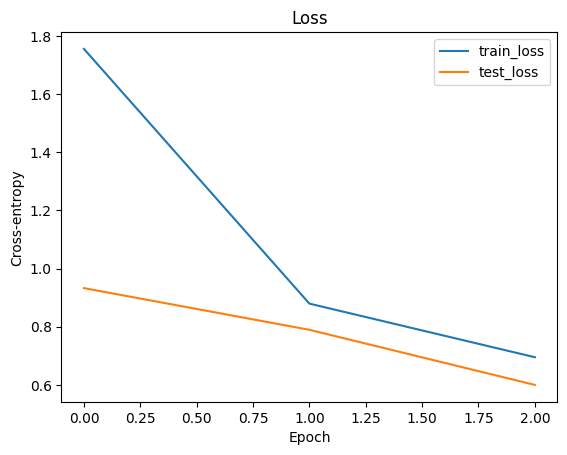

In [27]:
plt.plot(train_history, label="train_loss")
plt.plot(test_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy')
print(f"First train epoch loss - {train_history[0]}\nLast train epoch loss - {train_history[-1]}")
print(f"First test epoch loss - {test_history[0]}\nLast test epoch loss - {test_history[-1]}")

## Predict function

In [28]:
def predict(model: NeuralNetwork, X: np.ndarray) -> np.ndarray:
    y_preds = []
    for i in tqdm(range(X.shape[0])):
        y_preds.append(model.feedforward(X[i]))
    return np.array(y_preds)

In [29]:
y_pred = predict(CNN, x_test)

100%|██████████| 10000/10000 [04:18<00:00, 38.72it/s]


In [30]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [31]:
accuracy_score(y_pred_classes, y_test_classes)

0.8193

In [32]:
print(classification_report(y_test_classes, y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       980
           1       0.97      0.83      0.89      1135
           2       0.83      0.89      0.86      1032
           3       0.81      0.86      0.83      1010
           4       0.79      0.87      0.83       982
           5       0.77      0.72      0.74       892
           6       0.75      0.90      0.82       958
           7       0.91      0.79      0.85      1028
           8       0.68      0.73      0.71       974
           9       0.84      0.72      0.77      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



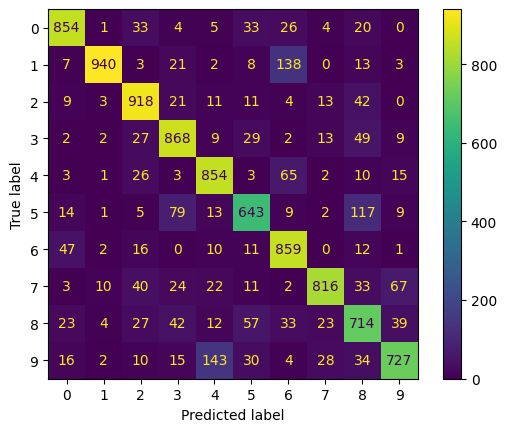

In [33]:
cm = confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()

All curves in one plot

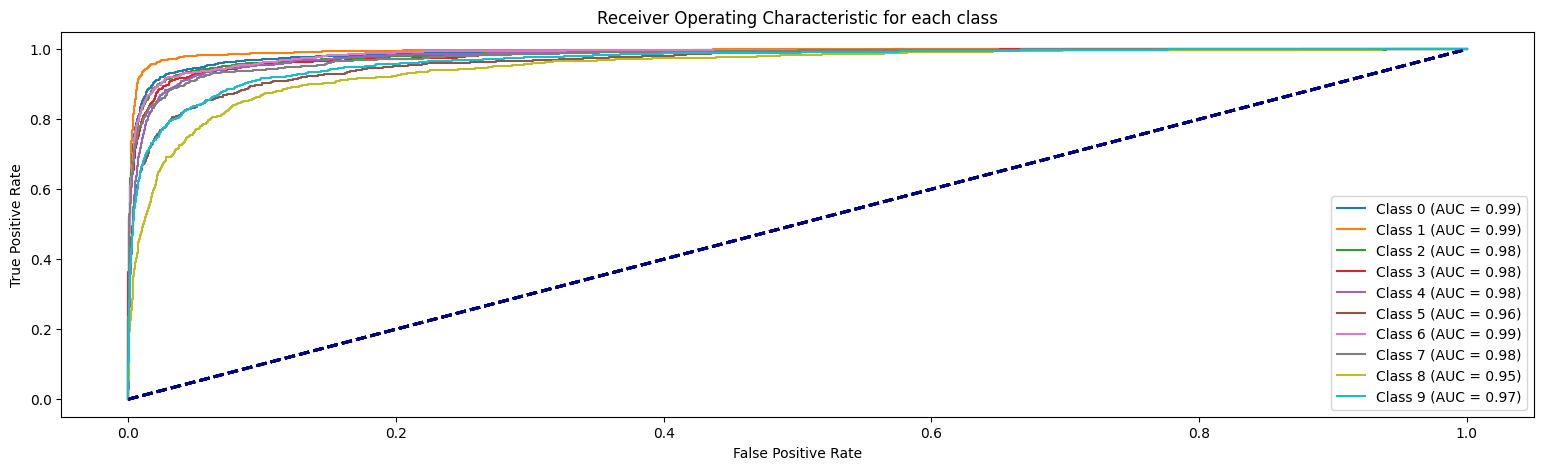

In [34]:
fig, ax = plt.subplots(figsize=(19, 5))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = round(auc(fpr, tpr), 4)

    ax.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic for each class')
ax.legend(loc="lower right")

One plot for each class

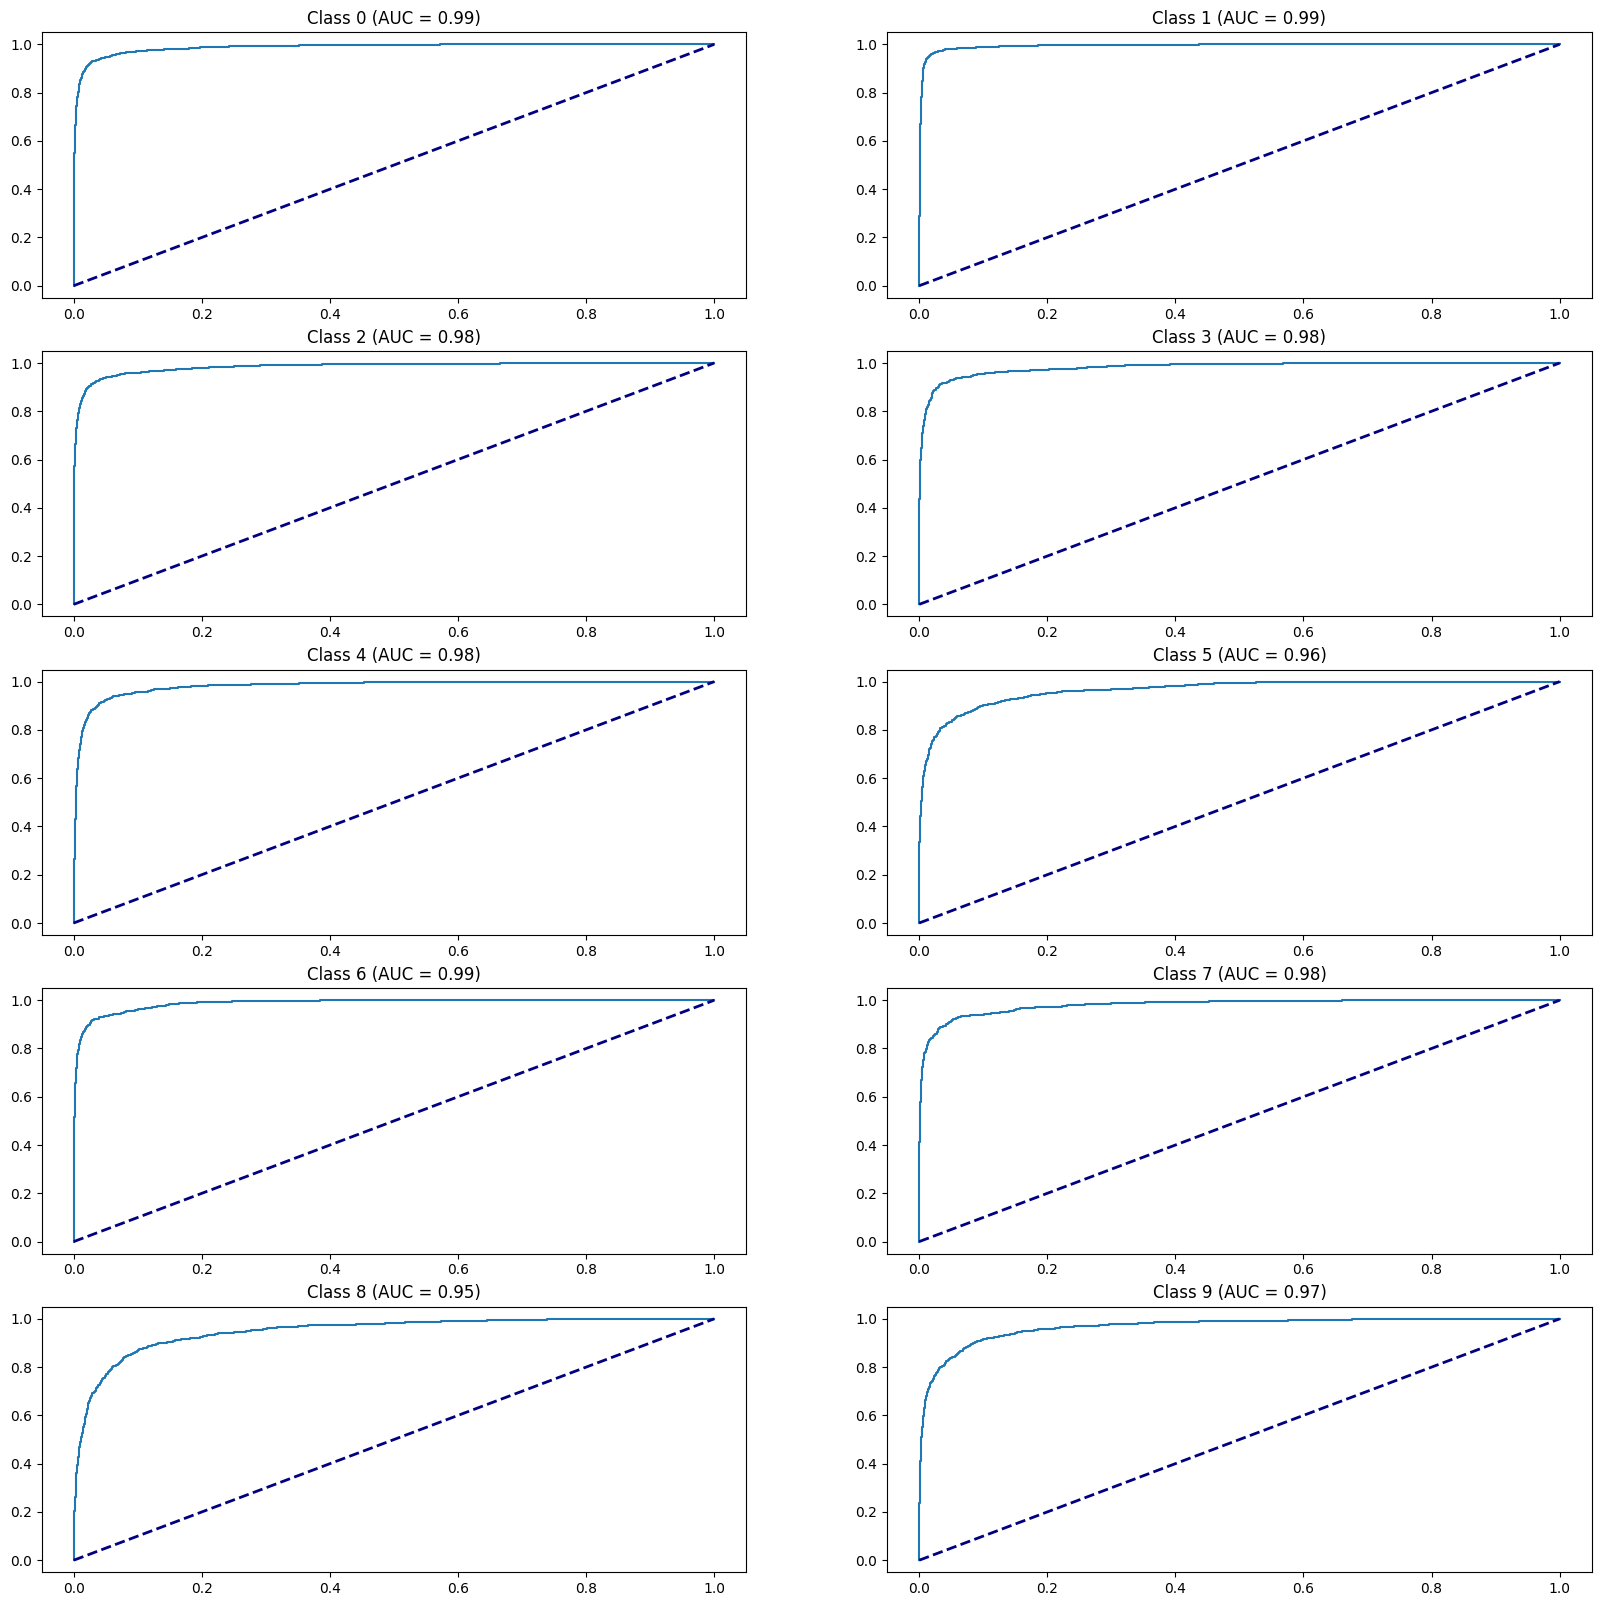

In [35]:
plt.rcParams["figure.figsize"] = (20, 20)

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = round(auc(fpr, tpr), 4)

    plt.subplot(5, 2, i + 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Class {} (AUC = {:.2f})'.format(i, roc_auc))